In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.models import Model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [6]:
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [19]:
n = 1000
min_f = 0
max_f = 3
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=3,
    d_phase=False,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 3)


In [20]:
x_train.shape

(1000, 100, 3, 1)

In [21]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(1000, 100, 3, 1), 900]

In [22]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 1)


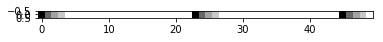

m (50, 1)


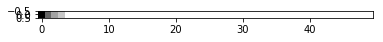

m (50, 1)


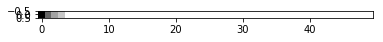

12 0


In [23]:
i = x_train.argmin()
j = x_train.argmax()
plot.single(x_train[i, :50,0])
plot.single(x_train[j, :50,0])
plot.single(x_train[0, :50,0])
print(i,j)

In [67]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(100, 3, 1)

In [68]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [69]:
def encoder(input_size, dropout=0.1):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='elu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    #     x = AveragePooling2D((2, 2))(x)
    h = Conv1D(128, kernel_size=2, strides=2, activation='relu', padding='same')(h)

    # Dense layers
    h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dropout(dropout)(h) # uncomment when using larger batches

    h = Dense(intermediate_dim, activation='relu')(h)
    #     h = Dense(intermediate_dim, activation='relu')(h)
    #     h = Dense(intermediate_dim, activation='relu')(h)    
    #     h = Dense(intermediate_dim, activation='relu')(h)
        # h = Dense(intermediate_dim, activation='relu', kernel_regularizer=k_reg, activity_regularizer=a_reg)(h)
    
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [70]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 100, 3)       0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 50, 32)       224         reshape_12[0][0]                 
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 50, 32)       2080        conv1d_28[0][0]                  
__________________________________________________________________________________________________
conv1d_30 

In [71]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [72]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [73]:
def list_decoders(output_size, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_size
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (channels, notes * m, timesteps)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(np.prod(output_shape[-3:]), activation='relu') ]
    decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolve & Pool
    
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
    decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
    decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
    # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
    decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
    decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
    decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    #     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
    decoders += [ Flatten()] # note that [].append != [] = []
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [74]:
decoders = list_decoders(input_shape)

In [75]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [76]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 244868      input_9[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          384         lambda_3[0][0]                   
__________

In [91]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae_loss = vae_loss()
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Users/mark/src/pattern-recognition/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Output "reshape_14" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_14" during training.
  if sys.path[0] == '':


In [92]:
# train the VAE on MNIST digits
# (x_train, _), (x_test, y_test) = mnist.load_data()

In [93]:
x_train.shape

(900, 100, 3, 1)

In [94]:
print('x_train.shape:', x_train.shape)

x_train.shape: (900, 100, 3, 1)


In [95]:
epochs = 2
batch_size = 100
params = {'batch_size': batch_size, 'return_y': False}

In [96]:
# put the custom batch_modifier at the end of this function
#  # Begin: Training with data augmentation ---------------------------------------------------------------------#
#     def train_generator(x, y, batch_size, shift_fraction=0.):
#         train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
#                                            height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
#         generator = train_datagen.flow(x, y, batch_size=batch_size)
#         while 1:
#             x_batch, y_batch = generator.next()
#             yield ([x_batch, y_batch], [y_batch, x_batch])

#     # Training with data augmentation. If shift_fraction=0., also no augmentation.
#     model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
#                         steps_per_epoch=int(y_train.shape[0] / args.batch_size),
#                         epochs=args.epochs,
#                         validation_data=[[x_test, y_test], [y_test, x_test]],
#                         callbacks=[log, tb, checkpoint, lr_decay])
# # End: Training with data augmentation -----------------------------------------------------------------------#

In [97]:
dataGenerator = False
# dataGenerator = True

if dataGenerator:
    X = models.DataGenerator(x_train, **params)
    # history = vae.fit(x_train,shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
    history = vae.fit_generator(
        X, epochs=epochs, steps_per_epoch=X.__len__(),
        use_multiprocessing=True, workers=2,
        validation_data=(x_test, None))
else:
       history = vae.fit(x_train, epochs=epochs, validation_data=(x_test, None))

Train on 900 samples, validate on 100 samples
Epoch 1/2
896/900 [============================>.] - ETA: 0s - loss: 204.3945

ValueError: operands could not be broadcast together with shapes (32,100,3) (4,100,3) (32,100,3) 

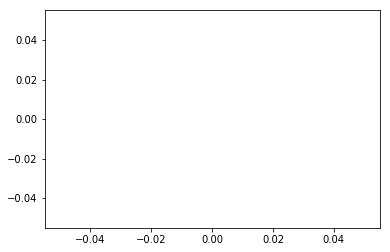

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

m (30, 1)


/Users/mark/src/pattern-recognition/envs/default/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/mark/src/pattern-recognition/envs/default/lib/python3.6/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


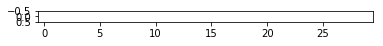

In [61]:
x = vae.predict(x_train[:10])
plot.single(x[0, :30, 0])

In [ ]:
# interpolate - mean
m = x.mean(axis=0)
plot.multi(m[:30])

In [ ]:
# interpolate - min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30])

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [ ]:
x_test.shape

In [ ]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

In [ ]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_test, alpha=0.1, s=30)

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [ ]:
# x_decoded[0].reshape(150,3)

In [ ]:
# display a 2D manifold of the digits
n = 3  # figure with 15x15 digits
digit_size1 = x_decoded.shape[-2]
digit_size2 = x_decoded.shape[-1]
figure = np.zeros((digit_size1 * n, digit_size1 * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size1, digit_size2)
        figure[i * digit_size1: (i + 1) * digit_size1,
               j * digit_size2: (j + 1) * digit_size2] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()